# Example notebook

This notebook will cover a regression case using scikit-learn's *California Housing* dataset.

In [1]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

X, y = fetch_california_housing(data_home='miraiml_local', return_X_y=True)
data = pd.DataFrame(X)
data['target'] = y

Let's split the data into training and testing data. In a real case scenario, we'd only have labels for training data.

In [2]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2)

## Building the search spaces

Let's compare (and ensemble) a `KNeighborsRegressor` and a pipeline composed by `StandardScaler` and a `LinearRegression`.

In [3]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from miraiml import SearchSpace
from miraiml.pipeline import compose

Pipeline = compose(
    [('scaler', StandardScaler), ('lin_reg', LinearRegression)]
)

search_spaces = [
    SearchSpace(
        id='k-NN Regressor',
        model_class=KNeighborsRegressor,
        parameters_values=dict(
            n_neighbors=range(2, 9),
            weights=['uniform', 'distance'],
            p=range(2, 5)
        )
    ),
    SearchSpace(
        id='Pipeline',
        model_class=Pipeline,
        parameters_values=dict(
            scaler__with_mean=[True, False],
            scaler__with_std=[True, False],
            lin_reg__fit_intercept=[True, False]
        )
    )
]

## Configuring the Engine

For this demonstration, let's use `r2_score` to evaluate our modeling.

In [4]:
from sklearn.metrics import r2_score

from miraiml import Config

config = Config(
    local_dir='miraiml_local',
    problem_type='regression',
    score_function=r2_score,
    search_spaces=search_spaces,
    ensemble_id='Ensemble'
)

## Triggering the Engine

Let's also print the scores everytime the Engine finds a better solution.

In [5]:
from miraiml import Engine

def on_improvement(status):
    scores = status.scores
    for key in sorted(scores.keys()):
        print('{}: {}'.format(key, round(scores[key], 3)), end='; ')
    print()

engine = Engine(config=config, on_improvement=on_improvement)

Now we're ready to load the data.

In [6]:
engine.load_train_data(train_data, 'target')
engine.load_test_data(test_data)

Let's leave it running for 2 minutes, shuffle the train data, let it run for 2 more minutes and then interrupt it.

In [7]:
from time import sleep

engine.restart()

sleep(120)

print('\nShuffling train data')
engine.shuffle_train_data(restart=True)

sleep(120)

engine.interrupt()

Ensemble: 0.118; Pipeline: -3.214; k-NN Regressor: 0.118; 
Ensemble: 0.142; Pipeline: -3.214; k-NN Regressor: 0.142; 
Ensemble: 0.143; Pipeline: 0.467; k-NN Regressor: 0.142; 
Ensemble: 0.474; Pipeline: 0.467; k-NN Regressor: 0.142; 
Ensemble: 0.473; Pipeline: 0.467; k-NN Regressor: 0.172; 
Ensemble: 0.509; Pipeline: 0.503; k-NN Regressor: 0.172; 
Ensemble: 0.509; Pipeline: 0.503; k-NN Regressor: 0.172; 
Ensemble: 0.525; Pipeline: 0.503; k-NN Regressor: 0.321; 
Ensemble: 0.539; Pipeline: 0.503; k-NN Regressor: 0.321; 
Ensemble: 0.552; Pipeline: 0.503; k-NN Regressor: 0.521; 
Ensemble: 0.566; Pipeline: 0.503; k-NN Regressor: 0.521; 
Ensemble: 0.565; Pipeline: 0.503; k-NN Regressor: 0.538; 
Ensemble: 0.566; Pipeline: 0.503; k-NN Regressor: 0.538; 
Ensemble: 0.566; Pipeline: 0.503; k-NN Regressor: 0.538; 
Ensemble: 0.566; Pipeline: 0.512; k-NN Regressor: 0.538; 
Ensemble: 0.566; Pipeline: 0.512; k-NN Regressor: 0.538; 
Ensemble: 0.566; Pipeline: 0.512; k-NN Regressor: 0.538; 
Ensemble: 0.

## Engine's status analysis

In [8]:
status = engine.request_status()

Let's see the status report.

In [9]:
print(status.build_report(include_features=True))

########################
best id: Ensemble
best score: 0.7583702712570008
########################
ensemble weights:
    k-NN Regressor: 0.4325346249356786
    Pipeline: 0.06615069839850787
########################
all scores:
    Ensemble: 0.7583702712570008
    k-NN Regressor: 0.7545806614607227
    Pipeline: 0.5963819838101254
########################
id: Pipeline
model class: MiraiPipeline
n features: 8
parameters:
    lin_reg__fit_intercept: True
    scaler__with_mean: False
    scaler__with_std: False
features: 0, 1, 2, 3, 4, 5, 6, 7
########################
id: k-NN Regressor
model class: KNeighborsRegressor
n features: 6
parameters:
    n_neighbors: 6
    p: 2
    weights: distance
features: 0, 2, 3, 5, 6, 7



### k-NN Regressor's history

How does the k-NN Regressor's scores change with `n_neighbors`, on average?

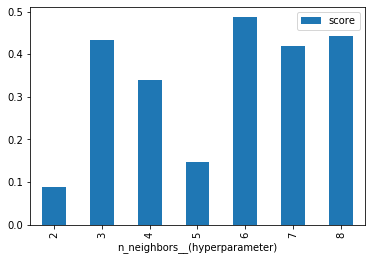

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

knn_history = status.histories['k-NN Regressor']

knn_history[['n_neighbors__(hyperparameter)', 'score']]\
    .groupby('n_neighbors__(hyperparameter)').mean()\
    .plot.bar()

plt.show()

We can also see how the presence of features (0 or 1) correlate with the score. These results can work as some sort of feature importance.

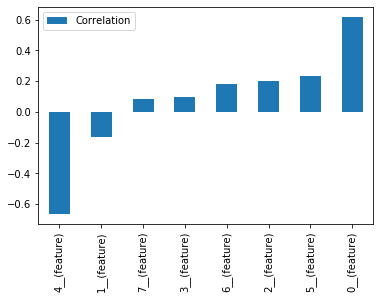

In [11]:
knn_history[[col for col in knn_history if col.endswith('(feature)')] + ['score']]\
    .corr()['score'][:-1]\
    .sort_values()\
    .plot.bar(label='Correlation')

plt.legend()
plt.show()

### Theoretical performance in production

Again, in practice we wouldn't have labels for `test_data`. But since we do have labels here, how would MiraiML perform on the test dataset?

In [12]:
r2_score(test_data['target'], status.test_predictions['Ensemble'])

0.7802410717298023